PPO Using PCA

# PCA classes

In [14]:
import sys, csv
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

class PCACompression:
    def __init__(self, pcaComponents, existingFile = None, fileNameBase="drive/MyDrive/Thesis/Code/RL_PCA/feature_data",  RGB = False):
        self.fileNames = []
        self.existingFile = existingFile
        self.fileNameBase = fileNameBase
        self.pca_main = PCA(n_components=pcaComponents)
        self.pcaStatistic = PCA()
        self.scaler = StandardScaler()
        self.RGB = RGB
        if ((existingFile is not None) and (existingFile is not "")):
            self.fileNames.append(existingFile)
        elif RGB:
            self.create_files(3)
        else:
            self.create_files()

    def create_files(self, counter=1):
        for i in range(counter):
            fileName = f'{self.fileNameBase}{i}.csv' if counter > 1 else f'{self.fileNameBase}.csv'
            try:
                with open(fileName, 'w') as fp:
                    pass
                self.fileNames.append(fileName)
            
            except Exception as e:
                print("Could not create file")
                print(e)
                sys.exit()
            
    def store_observation(self, data):
        self.write_RGB_data(data) if self.RGB else self.write_nonRGB_data(data)

    def write_RGB_data(self, data):
        pass

    def write_nonRGB_data(self,data):
        self.write_data(self.fileNames[0], data)

    def write_data(self, fileName, data):
        if not (isinstance(data, list) or isinstance(data, np.ndarray)):
            print("Invalid observation data type for function write\_data in PCA. Expected list or numpy.ndarray, got: " + str(type(data)))
            sys.exit()
        try:
            with open(fileName, mode='a') as fp:
                data_writer = csv.writer(fp, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                data_writer.writerow(data)
        except Exception as e:
            print("Writing data to csv failed.")
            print(e)
            sys.exit()

    def create_pca(self):
        if self.RGB:
            #TODO
            dfR = pd.read_csv(self.fileNames[0])
            dfG = pd.read_csv(self.fileNames[1])
            dfB = pd.read_csv(self.fileNames[2])
        else:
            df = pd.read_csv(self.fileNames[0])
            self.scaler.fit(df)
            df = self.scaler.transform(df)
            self.pca_main.fit(df)
            self.pcaStatistic.fit(df)
            
    def update_pca(self, dimensions):
        if self.RGB:
            #TODO
            dfR = pd.read_csv(self.fileNames[0])
            dfG = pd.read_csv(self.fileNames[1])
            dfB = pd.read_csv(self.fileNames[2])
        else:
            df = pd.read_csv(self.fileNames[0])
            self.scaler.fit(df)
            df = self.scaler.transform(df)
            self.pca_main = PCA(n_components=dimensions)
            self.pca_main.fit(df)
            self.pcaStatistic.fit(df)

    def apply_pca(self, observation):
        if self.RGB:
            pass
        else:
            obs = self.scaler.transform([observation])
            return self.pca_main.transform(obs)[0]

    def get_pca_dimension_info(self):
        return np.cumsum(self.pcaStatistic.explained_variance_ratio_)

# PPO using PCA

In [ ]:
# https://github.com/RPC2/PPO

In [2]:
import torch
import torch.nn as nn


class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

In [3]:
class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 400

    train_cartpole = True

In [19]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent(AgentConfig):
    def __init__(self, env, observation_space):
        self.env = env
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size, input_size = observation_space).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.tensor([], dtype=torch.float)
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        screen, reward, terminal, info = self.env.step(action)
        return screen, reward, action, terminal

    def train(self, pca_manager, pca_fit, num_episodes):
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        for episode in range (1,num_episodes+1):
            start_step = step
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            state_mem = state
            state = torch.tensor(state, dtype=torch.float, device=device)
            if not pca_fit: 
                with torch.no_grad():
                  state = torch.tensor(pca_manager.apply_pca(state.cpu().numpy()), dtype=torch.float, device=device)
                  state_mem = state.tolist()
            else:
                pca_manager.store_observation(state.cpu().numpy())
            total_episode_reward = 1
            # A step in an episode
            while True:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(state)
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                new_state, reward, terminal, _ = self.env.step(action)
                new_state_mem = new_state
                new_state = torch.tensor(new_state, dtype=torch.float, device=device)
                
                if not pca_fit:
                    with torch.no_grad():
                      new_state = torch.tensor(pca_manager.apply_pca(new_state.cpu().numpy()), dtype=torch.float, device=device)
                      new_state_mem = new_state.tolist()
                else:
                    pca_manager.store_observation(new_state.cpu().numpy())
                
                reward = -1 if terminal else reward

                self.add_memory(state_mem, action, reward/10.0, new_state_mem, terminal, prob_a[action].item())
                state = new_state
                state_mem = new_state_mem
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    # print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                    #           'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                    #                                     self.scheduler.get_last_lr()[0]))
                    if not pca_fit:
                        print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                              'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                        self.scheduler.get_last_lr()[0]))
                    else:
                        print(f'Fitted PCA for episode {episode} of {num_episodes}.')  

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0 and not pca_fit:
                plot_graph(reward_history, avg_reward)

        self.env.close()

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.tensor(self.memory['state'], dtype=torch.float, device=device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action'], device=device))
        old_probs_a = torch.tensor(self.memory['action_prob'], dtype=torch.float, device=device)
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.tensor(self.memory['advantage'], dtype=torch.float, device=device)
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.tensor(self.memory['advantage'], dtype=torch.float, device=device)
        pred_v = self.policy_network.v(torch.tensor(self.memory['state'], dtype=torch.float, device=device))
        v_loss = (0.5 * (pred_v - self.memory['td_target']).pow(2)).to('cpu')  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = ((-torch.min(surr1, surr2)).to('cpu') + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.tensor(reward, device=device) + \
                    self.gamma * self.policy_network.v(torch.tensor(next_state, dtype=torch.float,device=device)) * torch.tensor(terminal, device=device)
        delta = (td_target - self.policy_network.v(torch.tensor(state, dtype=torch.float,device=device))).to('cpu')
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'].to(device), td_target.data), dim=0)
        self.memory['advantage'] += advantages


def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(df['x'], df['Reward'], marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')
    # plt.plot(df['x'], df['Average'], marker='', color='tomato', linewidth=1, alpha=0.9, label='Average')

    # plt.legend(loc='upper left')
    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

Demo Trajectories for fitting VAE
Fitted PCA for episode 1 of 20.
Fitted PCA for episode 2 of 20.
Fitted PCA for episode 3 of 20.
Fitted PCA for episode 4 of 20.
Fitted PCA for episode 5 of 20.
Fitted PCA for episode 6 of 20.
Fitted PCA for episode 7 of 20.
Fitted PCA for episode 8 of 20.
Fitted PCA for episode 9 of 20.
Fitted PCA for episode 10 of 20.
Fitted PCA for episode 11 of 20.
Fitted PCA for episode 12 of 20.
Fitted PCA for episode 13 of 20.
Fitted PCA for episode 14 of 20.
Fitted PCA for episode 15 of 20.
Fitted PCA for episode 16 of 20.
Fitted PCA for episode 17 of 20.
Fitted PCA for episode 18 of 20.
Fitted PCA for episode 19 of 20.
Fitted PCA for episode 20 of 20.
PCA component information percentages:
[0.75856866 0.94276862 0.99779019 1.        ]
Actual trajectories
episode: 1.00, total step: 18.00, last_episode length: 18.00, last_episode_reward: 17.00, loss: 0.0000, lr: 0.0200
episode: 2.00, total step: 30.00, last_episode length: 12.00, last_episode_reward: 11.00, loss:

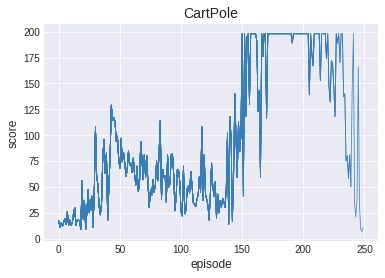

In [21]:
environment = gym.make('CartPole-v0')
observation_space = environment.observation_space.shape[0]

#Hyperparameters PCA
latent_space = 4 # Feature space after PCA transform

existingFile = "" #"drive/MyDrive/Thesis/Code/RL_PCA/feature_data.csv" # Possible existing file name containing observations for VAE fitting

pca_manager = PCACompression(pcaComponents=latent_space, existingFile= existingFile)

#Fit PCA by getting demo trajectories
if existingFile is None or existingFile == "":
    print("Demo Trajectories for fitting VAE")
    num_episodes = 20
    agent = Agent(environment, observation_space)
    agent.train(pca_manager, pca_fit = True, num_episodes = num_episodes)

# Fit PCA on the trajectory data in the file
pca_manager.create_pca()
print(f'PCA component information percentages:\n{pca_manager.get_pca_dimension_info()}')

#Run actual Episodes
print("Actual trajectories")
num_episodes = 250
agent = Agent(environment, latent_space)
agent.train(pca_manager, pca_fit = False, num_episodes = num_episodes)